# 💳 Fraud Detection - Model Training

This notebook trains multiple machine learning models for fraud detection using the preprocessed transaction data.

**Models Trained:**
1. **Logistic Regression** - Baseline linear model
2. **Decision Tree** - Interpretable tree-based model  
3. **Random Forest** - Ensemble of decision trees
4. **XGBoost** - Gradient boosting (best for imbalanced data)
5. **LightGBM** - Fast gradient boosting
6. **Gradient Boosting** - Scikit-learn ensemble method

**Data Source:** `train_transaction_processed.csv` (feature-engineered dataset from EDA)

**Class Imbalance Handling:**
- SMOTE (Synthetic Minority Over-sampling) with 0.3 ratio
- Class weights balancing
- Stratified train-validation split

**Output:** Trained models saved as PKL files for evaluation

## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
import time

# Machine Learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Try to import XGBoost and LightGBM
try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    xgboost_available = False
    print("⚠ XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    lightgbm_available = True
except ImportError:
    lightgbm_available = False
    print("⚠ LightGBM not available. Install with: pip install lightgbm")

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Metrics for quick evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ All libraries imported successfully")
if xgboost_available:
    print("✓ XGBoost available")
if lightgbm_available:
    print("✓ LightGBM available")

✓ All libraries imported successfully
✓ XGBoost available
✓ LightGBM available


In [2]:
# Load preprocessed data from EDA notebook
print("Loading preprocessed data from EDA...\n")

# Load the processed dataset with feature engineering
train_data = pd.read_csv('train_transaction_processed.csv')

print(f"✓ Data loaded: {train_data.shape}")
print(f"Columns: {train_data.shape[1]}")
print(f"Rows: {train_data.shape[0]:,}")
print(f"\nNote: Using train_transaction_processed.csv with engineered features")

Loading preprocessed data from EDA...

✓ Data loaded: (590540, 429)
Columns: 429
Rows: 590,540

Note: Using train_transaction_processed.csv with engineered features


In [3]:
# Separate features and target
if 'isFraud' in train_data.columns:
    X = train_data.drop(columns=['isFraud'])
    y = train_data['isFraud']
else:
    raise ValueError("Target variable 'isFraud' not found in dataset")

# Remove ID columns if present
id_cols = ['TransactionID', 'TransactionDT']
X = X.drop(columns=[col for col in id_cols if col in X.columns], errors='ignore')

# Handle any remaining missing values
X = X.fillna(0)

# Select only numeric columns for training
X = X.select_dtypes(include=[np.number])

print(f"\n📊 Dataset Overview:")
print(f"   Features: {X.shape[1]}")
print(f"   Samples: {X.shape[0]:,}")
print(f"\n🎯 Target Distribution:")
print(f"   Not Fraud: {(y == 0).sum():,} ({(y == 0).sum()/len(y)*100:.2f}%)")
print(f"   Fraud: {(y == 1).sum():,} ({(y == 1).sum()/len(y)*100:.2f}%)")
print(f"   Imbalance Ratio: 1:{(y == 0).sum() // (y == 1).sum()}")

# Stratified train-validation split (80-20)
print(f"\n📂 Creating stratified train-validation split (80-20)...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain fraud ratio
)

print(f"✓ Train set: {X_train.shape[0]:,} samples")
print(f"✓ Validation set: {X_val.shape[0]:,} samples")
print(f"\nTrain fraud rate: {y_train.mean()*100:.2f}%")
print(f"Validation fraud rate: {y_val.mean()*100:.2f}%")


📊 Dataset Overview:
   Features: 411
   Samples: 590,540

🎯 Target Distribution:
   Not Fraud: 569,877 (96.50%)
   Fraud: 20,663 (3.50%)
   Imbalance Ratio: 1:27

📂 Creating stratified train-validation split (80-20)...
✓ Train set: 472,432 samples
✓ Validation set: 118,108 samples

Train fraud rate: 3.50%
Validation fraud rate: 3.50%


## 2. Handle Class Imbalance with SMOTE

APPLYING SMOTE TO BALANCE CLASSES

Before SMOTE:
Training samples: 472,432
Fraud cases: 16,530 (3.50%)
Not Fraud cases: 455,902 (96.50%)

After SMOTE:
Training samples: 592,672
Fraud cases: 136,770 (23.08%)
Not Fraud cases: 455,902 (76.92%)

✓ SMOTE applied successfully
Note: Using 0.3 ratio for better generalization on highly imbalanced data


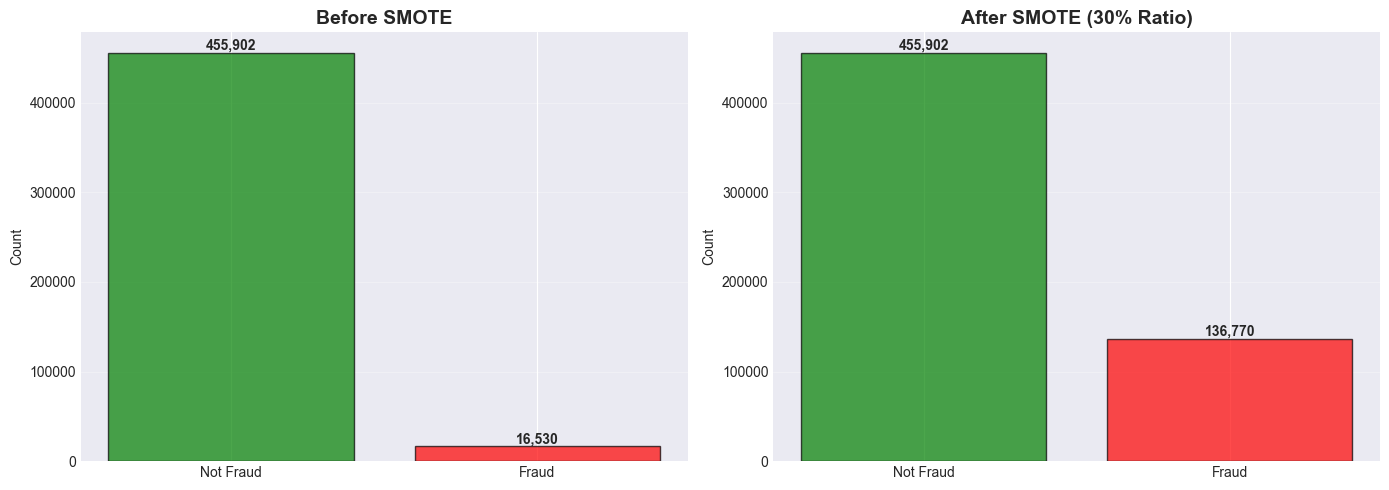

In [4]:
print(f"{'='*80}")
print("APPLYING SMOTE TO BALANCE CLASSES")
print(f"{'='*80}\n")

print("Before SMOTE:")
print(f"Training samples: {len(X_train):,}")
print(f"Fraud cases: {y_train.sum():,} ({(y_train.sum()/len(y_train))*100:.2f}%)")
print(f"Not Fraud cases: {(y_train == 0).sum():,} ({((y_train == 0).sum()/len(y_train))*100:.2f}%)")

# Apply SMOTE with optimal sampling strategy for fraud detection
# Using 0.3 ratio - fraud becomes 30% of majority (better than 50% for high imbalance)
smote = SMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(f"Training samples: {len(X_train_smote):,}")
print(f"Fraud cases: {y_train_smote.sum():,} ({(y_train_smote.sum()/len(y_train_smote))*100:.2f}%)")
print(f"Not Fraud cases: {(y_train_smote == 0).sum():,} ({((y_train_smote == 0).sum()/len(y_train_smote))*100:.2f}%)")

print("\n✓ SMOTE applied successfully")
print("Note: Using 0.3 ratio for better generalization on highly imbalanced data")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
axes[0].bar(['Not Fraud', 'Fraud'], [(y_train == 0).sum(), y_train.sum()], 
            color=['green', 'red'], edgecolor='black', alpha=0.7)
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate([(y_train == 0).sum(), y_train.sum()]):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# After SMOTE
axes[1].bar(['Not Fraud', 'Fraud'], [(y_train_smote == 0).sum(), y_train_smote.sum()], 
            color=['green', 'red'], edgecolor='black', alpha=0.7)
axes[1].set_title('After SMOTE (30% Ratio)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate([(y_train_smote == 0).sum(), y_train_smote.sum()]):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Model Training Helper Function

In [5]:
def train_and_evaluate_model(model, model_name, X_train, y_train, X_val, y_val):
    """
    Train a model and return comprehensive evaluation metrics including confusion matrix
    """
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*80}\n")
    
    # Training
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"✓ Model trained in {training_time:.2f} seconds")
    
    # Predictions
    y_pred = model.predict(X_val)
    
    # Get probability scores if available
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_pred_proba = model.decision_function(X_val)
    else:
        y_pred_proba = None
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    cm = confusion_matrix(y_val, y_pred)
    
    print(f"\n📊 Validation Results:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f} (of predicted frauds, how many are correct)")
    print(f"   Recall:    {recall:.4f} (of actual frauds, how many we caught)")
    print(f"   F1-Score:  {f1:.4f} (harmonic mean of precision & recall)")
    
    if y_pred_proba is not None:
        try:
            roc_auc = roc_auc_score(y_val, y_pred_proba)
            print(f"   ROC-AUC:   {roc_auc:.4f}")
        except:
            roc_auc = None
    else:
        roc_auc = None
    
    print(f"\n📈 Confusion Matrix:")
    print(f"   TN: {cm[0,0]:6,}  |  FP: {cm[0,1]:6,}")
    print(f"   FN: {cm[1,0]:6,}  |  TP: {cm[1,1]:6,}")
    
    return {
        'model_name': model_name,
        'model': model,
        'training_time': training_time,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

print("✓ Training function defined")

✓ Training function defined


## 4. Model 1: Logistic Regression (Baseline)

In [6]:
# Logistic Regression - Good baseline for binary classification
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',  # Handle imbalance
    solver='lbfgs',  # Good for large datasets
    C=1.0  # Regularization strength
)

lr_results = train_and_evaluate_model(
    lr_model, "Logistic Regression",
    X_train_smote, y_train_smote, X_val, y_val
)

# Save model
with open('model_logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("\n✓ Model saved: model_logistic_regression.pkl")


TRAINING: Logistic Regression

✓ Model trained in 253.79 seconds

📊 Validation Results:
   Accuracy:  0.7809
   Precision: 0.1024 (of predicted frauds, how many are correct)
   Recall:    0.6780 (of actual frauds, how many we caught)
   F1-Score:  0.1780 (harmonic mean of precision & recall)
   ROC-AUC:   0.7945

📈 Confusion Matrix:
   TN: 89,426  |  FP: 24,549
   FN:  1,331  |  TP:  2,802

✓ Model saved: model_logistic_regression.pkl


## 5. Model 2: Decision Tree (Interpretable)

In [7]:
# Decision Tree - Interpretable model with pruning to prevent overfitting
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=15,  # Increased from 10 for better performance
    min_samples_split=50,  # Reduced for more splits
    min_samples_leaf=25,  # Minimum samples per leaf
    class_weight='balanced',
    criterion='gini'  # or 'entropy'
)

dt_results = train_and_evaluate_model(
    dt_model, "Decision Tree",
    X_train_smote, y_train_smote, X_val, y_val
)

print(f"\nTree Statistics:")
print(f"   Tree depth: {dt_model.get_depth()}")
print(f"   Number of leaves: {dt_model.get_n_leaves()}")

# Save model
with open('model_decision_tree.pkl', 'wb') as f:
    pickle.dump(dt_model, f)
print("\n✓ Model saved: model_decision_tree.pkl")


TRAINING: Decision Tree

✓ Model trained in 64.96 seconds

📊 Validation Results:
   Accuracy:  0.9378
   Precision: 0.2997 (of predicted frauds, how many are correct)
   Recall:    0.5812 (of actual frauds, how many we caught)
   F1-Score:  0.3955 (harmonic mean of precision & recall)
   ROC-AUC:   0.8519

📈 Confusion Matrix:
   TN: 108,362  |  FP:  5,613
   FN:  1,731  |  TP:  2,402

Tree Statistics:
   Tree depth: 15
   Number of leaves: 1624

✓ Model saved: model_decision_tree.pkl


## 6. Model 3: Random Forest (Ensemble - Recommended)

In [8]:
# Random Forest - Best balance of performance and interpretability
rf_model = RandomForestClassifier(
    n_estimators=200,  # More trees for better performance
    random_state=42,
    max_depth=20,  # Deeper trees
    min_samples_split=20,  # More aggressive splitting
    min_samples_leaf=10,
    max_features='sqrt',  # Good default for classification
    class_weight='balanced',
    n_jobs=-1,  # Use all CPU cores
    bootstrap=True
)

rf_results = train_and_evaluate_model(
    rf_model, "Random Forest",
    X_train_smote, y_train_smote, X_val, y_val
)

print(f"\nModel Statistics:")
print(f"   Number of trees: {rf_model.n_estimators}")
print(f"   Max features per split: sqrt({X_train.shape[1]}) = {int(np.sqrt(X_train.shape[1]))}")

# Save model
with open('model_random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("\n✓ Model saved: model_random_forest.pkl")


TRAINING: Random Forest

✓ Model trained in 200.18 seconds

📊 Validation Results:
   Accuracy:  0.9740
   Precision: 0.6471 (of predicted frauds, how many are correct)
   Recall:    0.5669 (of actual frauds, how many we caught)
   F1-Score:  0.6043 (harmonic mean of precision & recall)
   ROC-AUC:   0.9201

📈 Confusion Matrix:
   TN: 112,697  |  FP:  1,278
   FN:  1,790  |  TP:  2,343

Model Statistics:
   Number of trees: 200
   Max features per split: sqrt(411) = 20

✓ Model saved: model_random_forest.pkl


## 7. Model 4: XGBoost (Gradient Boosting)

In [9]:
if xgboost_available:
    # XGBoost - Excellent for imbalanced classification
    # Calculate scale_pos_weight for imbalance
    scale_pos_weight = (y_train_smote == 0).sum() / (y_train_smote == 1).sum()
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,  # Row sampling
        colsample_bytree=0.8,  # Column sampling
        gamma=0,  # Minimum loss reduction
        min_child_weight=3,
        scale_pos_weight=scale_pos_weight,  # Handle imbalance
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    xgb_results = train_and_evaluate_model(
        xgb_model, "XGBoost",
        X_train_smote, y_train_smote, X_val, y_val
    )
    
    print(f"\nModel Statistics:")
    print(f"   Number of boosting rounds: {xgb_model.n_estimators}")
    print(f"   Scale pos weight: {scale_pos_weight:.2f}")
    
    # Save model
    xgb_model.save_model('model_xgboost.json')
    print("\n✓ Model saved: model_xgboost.json")
else:
    print("⚠ XGBoost not available. Skipping...")
    xgb_results = None


TRAINING: XGBoost

✓ Model trained in 76.81 seconds
✓ Model trained in 76.81 seconds

📊 Validation Results:
   Accuracy:  0.9830
   Precision: 0.8164 (of predicted frauds, how many are correct)
   Recall:    0.6627 (of actual frauds, how many we caught)
   F1-Score:  0.7316 (harmonic mean of precision & recall)
   ROC-AUC:   0.9624

📈 Confusion Matrix:
   TN: 113,359  |  FP:    616
   FN:  1,394  |  TP:  2,739

Model Statistics:
   Number of boosting rounds: 200
   Scale pos weight: 3.33

✓ Model saved: model_xgboost.json

📊 Validation Results:
   Accuracy:  0.9830
   Precision: 0.8164 (of predicted frauds, how many are correct)
   Recall:    0.6627 (of actual frauds, how many we caught)
   F1-Score:  0.7316 (harmonic mean of precision & recall)
   ROC-AUC:   0.9624

📈 Confusion Matrix:
   TN: 113,359  |  FP:    616
   FN:  1,394  |  TP:  2,739

Model Statistics:
   Number of boosting rounds: 200
   Scale pos weight: 3.33

✓ Model saved: model_xgboost.json


## 8. Model 5: LightGBM (Fast Gradient Boosting)

In [10]:
if lightgbm_available:
    # LightGBM - Fast and efficient gradient boosting
    lgb_model = lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=15,
        learning_rate=0.1,
        num_leaves=31,  # Should be < 2^max_depth
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=20,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    lgb_results = train_and_evaluate_model(
        lgb_model, "LightGBM",
        X_train_smote, y_train_smote, X_val, y_val
    )
    
    print(f"\nModel Statistics:")
    print(f"   Number of boosting rounds: {lgb_model.n_estimators}")
    print(f"   Number of leaves: {lgb_model.num_leaves}")
    
    # Save model
    with open('model_lightgbm.pkl', 'wb') as f:
        pickle.dump(lgb_model, f)
    print("\n✓ Model saved: model_lightgbm.pkl")
else:
    print("⚠ LightGBM not available. Skipping...")
    lgb_results = None


TRAINING: LightGBM

✓ Model trained in 34.55 seconds
✓ Model trained in 34.55 seconds

📊 Validation Results:
   Accuracy:  0.9750
   Precision: 0.6616 (of predicted frauds, how many are correct)
   Recall:    0.5846 (of actual frauds, how many we caught)
   F1-Score:  0.6207 (harmonic mean of precision & recall)
   ROC-AUC:   0.9340

📈 Confusion Matrix:
   TN: 112,739  |  FP:  1,236
   FN:  1,717  |  TP:  2,416

Model Statistics:
   Number of boosting rounds: 200
   Number of leaves: 31

✓ Model saved: model_lightgbm.pkl

📊 Validation Results:
   Accuracy:  0.9750
   Precision: 0.6616 (of predicted frauds, how many are correct)
   Recall:    0.5846 (of actual frauds, how many we caught)
   F1-Score:  0.6207 (harmonic mean of precision & recall)
   ROC-AUC:   0.9340

📈 Confusion Matrix:
   TN: 112,739  |  FP:  1,236
   FN:  1,717  |  TP:  2,416

Model Statistics:
   Number of boosting rounds: 200
   Number of leaves: 31

✓ Model saved: model_lightgbm.pkl


## 9. Model 6: Gradient Boosting (Scikit-learn)

In [11]:
# Gradient Boosting - Powerful ensemble method
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,  # Stochastic gradient boosting
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    validation_fraction=0.1,  # For early stopping monitoring
    n_iter_no_change=10  # Early stopping
)

gb_results = train_and_evaluate_model(
    gb_model, "Gradient Boosting",
    X_train_smote, y_train_smote, X_val, y_val
)

print(f"\nModel Statistics:")
print(f"   Number of boosting stages: {gb_model.n_estimators}")
print(f"   Effective estimators used: {gb_model.n_estimators_}")

# Save model
with open('model_gradient_boosting.pkl', 'wb') as f:
    pickle.dump(gb_model, f)
print("\n✓ Model saved: model_gradient_boosting.pkl")


TRAINING: Gradient Boosting

✓ Model trained in 602.36 seconds
✓ Model trained in 602.36 seconds

📊 Validation Results:
   Accuracy:  0.9818
   Precision: 0.9073 (of predicted frauds, how many are correct)
   Recall:    0.5352 (of actual frauds, how many we caught)
   F1-Score:  0.6733 (harmonic mean of precision & recall)
   ROC-AUC:   0.9477

📈 Confusion Matrix:
   TN: 113,749  |  FP:    226
   FN:  1,921  |  TP:  2,212

Model Statistics:
   Number of boosting stages: 200
   Effective estimators used: 200

✓ Model saved: model_gradient_boosting.pkl

📊 Validation Results:
   Accuracy:  0.9818
   Precision: 0.9073 (of predicted frauds, how many are correct)
   Recall:    0.5352 (of actual frauds, how many we caught)
   F1-Score:  0.6733 (harmonic mean of precision & recall)
   ROC-AUC:   0.9477

📈 Confusion Matrix:
   TN: 113,749  |  FP:    226
   FN:  1,921  |  TP:  2,212

Model Statistics:
   Number of boosting stages: 200
   Effective estimators used: 200

✓ Model saved: model_grad

## 10. Compile and Save All Results

In [12]:
# Compile all results
all_results = [lr_results, dt_results, rf_results]

if xgboost_available and xgb_results:
    all_results.append(xgb_results)

if lightgbm_available and lgb_results:
    all_results.append(lgb_results)

all_results.append(gb_results)

# Create summary DataFrame
results_summary = pd.DataFrame([{
    'Model': r['model_name'],
    'Training Time (s)': r['training_time'],
    'Accuracy': r['accuracy'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'F1-Score': r['f1'],
    'ROC-AUC': r['roc_auc'] if r['roc_auc'] else 'N/A'
} for r in all_results])

print(f"\n{'='*80}")
print("TRAINING SUMMARY - ALL MODELS")
print(f"{'='*80}\n")
print(results_summary.to_string(index=False))

# Save results
results_summary.to_csv('training_results_summary.csv', index=False)
print(f"\n✓ Training summary saved: training_results_summary.csv")

# Save all results for evaluation notebook
with open('all_model_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)
print(f"✓ All model results saved: all_model_results.pkl")

# Save train/val split for evaluation
with open('train_val_split.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'X_val': X_val,
        'y_train': y_train,
        'y_val': y_val,
        'X_train_smote': X_train_smote,
        'y_train_smote': y_train_smote
    }, f)
print(f"✓ Train/val split saved: train_val_split.pkl")



TRAINING SUMMARY - ALL MODELS

              Model  Training Time (s)  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression         253.787112  0.780879   0.102446 0.677958  0.177995 0.794543
      Decision Tree          64.960482  0.937820   0.299688 0.581176  0.395456 0.851948
      Random Forest         200.179184  0.974024   0.647059 0.566901  0.604333 0.920100
            XGBoost          76.806084  0.982982   0.816393 0.662715  0.731571 0.962368
           LightGBM          34.552045  0.974997   0.661555 0.584563  0.620681 0.934037
  Gradient Boosting         602.361072  0.981822   0.907301 0.535204  0.673261 0.947717

✓ Training summary saved: training_results_summary.csv
✓ All model results saved: all_model_results.pkl
✓ All model results saved: all_model_results.pkl
✓ Train/val split saved: train_val_split.pkl
✓ Train/val split saved: train_val_split.pkl


## 11. Training Complete - Summary

In [13]:
print(f"\n{'='*80}")
print("✅ MODEL TRAINING COMPLETE!")
print(f"{'='*80}\n")

print(f"📊 Trained {len(all_results)} models:")
for i, r in enumerate(all_results, 1):
    print(f"   {i}. {r['model_name']}")
    print(f"      • F1-Score: {r['f1']:.4f}")
    print(f"      • Recall: {r['recall']:.4f}")
    print(f"      • Training Time: {r['training_time']:.2f}s")

# Find best model by F1-score
best_model = max(all_results, key=lambda x: x['f1'])
print(f"\n🏆 Best Model (by F1-Score): {best_model['model_name']}")
print(f"   F1-Score: {best_model['f1']:.4f}")

print(f"\n📁 Generated Files:")
print(f"   Models:")
print(f"   • model_logistic_regression.pkl")
print(f"   • model_decision_tree.pkl")
print(f"   • model_random_forest.pkl")
if xgboost_available:
    print(f"   • model_xgboost.json")
if lightgbm_available:
    print(f"   • model_lightgbm.pkl")
print(f"   • model_gradient_boosting.pkl")

print(f"\n   Results:")
print(f"   • training_results_summary.csv")
print(f"   • all_model_results.pkl")
print(f"   • train_val_split.pkl")

print(f"\n💡 Next Steps:")
print(f"   1. Open Model_Evaluation.ipynb for detailed model comparison")
print(f"   2. Analyze confusion matrices, ROC curves, and feature importance")
print(f"   3. Select the best model based on business requirements")
print(f"   4. Apply the best model to test_transaction.csv")

print(f"\n{'='*80}")
print(f"Proceed to Model_Evaluation.ipynb for comprehensive evaluation!")
print(f"{'='*80}")



✅ MODEL TRAINING COMPLETE!

📊 Trained 6 models:
   1. Logistic Regression
      • F1-Score: 0.1780
      • Recall: 0.6780
      • Training Time: 253.79s
   2. Decision Tree
      • F1-Score: 0.3955
      • Recall: 0.5812
      • Training Time: 64.96s
   3. Random Forest
      • F1-Score: 0.6043
      • Recall: 0.5669
      • Training Time: 200.18s
   4. XGBoost
      • F1-Score: 0.7316
      • Recall: 0.6627
      • Training Time: 76.81s
   5. LightGBM
      • F1-Score: 0.6207
      • Recall: 0.5846
      • Training Time: 34.55s
   6. Gradient Boosting
      • F1-Score: 0.6733
      • Recall: 0.5352
      • Training Time: 602.36s

🏆 Best Model (by F1-Score): XGBoost
   F1-Score: 0.7316

📁 Generated Files:
   Models:
   • model_logistic_regression.pkl
   • model_decision_tree.pkl
   • model_random_forest.pkl
   • model_xgboost.json
   • model_lightgbm.pkl
   • model_gradient_boosting.pkl

   Results:
   • training_results_summary.csv
   • all_model_results.pkl
   • train_val_split.pkl
